In [3]:
import time
import pickle

import scipy
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

import torch
import torch.nn as nn

import deepinv

from pnp_unrolling.unrolled_cdl import UnrolledCDL
from utils.measurement_tools import get_operators
from utils.tools import op_norm2
from pnp_unrolling.datasets import (
    create_imagenet_dataloader,
)


def plot_img(img, ax, title=None):
    img = img.detach().cpu().numpy().transpose(1, 2, 0).clip(0, 1)
    ax.imshow(img)
    ax.set_axis_off()
    if title:
        ax.set_title(title)


DATASET = "bsd"
COLOR = True
DEVICE = "cuda:0" #"cuda:3"
STD_NOISE = 0.05

# Here the dataset is "BSD" but we use the same create_imagenet_dataloader
# function which need to set dataset="imagenet"
create_dataloader = create_imagenet_dataloader
DATA_PATH = "./BSDS500/BSDS500/data/images"
DATASET = "imagenet"

### Training the denoisers

In [4]:
params_model_1l_50c = {
    "n_layers": 1,
    "n_components": 50,
    "kernel_size": 5,
    "lmbd": 1e-4,
    "color": COLOR,
    "device": DEVICE,
    "dtype": torch.float,
    "optimizer": "adam",
    "path_data": DATA_PATH,
    "max_sigma_noise": STD_NOISE,
    "min_sigma_noise": STD_NOISE,
    "mini_batch_size": 1,
    "max_batch": 10,
    "epochs": 50,
    "avg": False,
    "rescale": False,
    "fixed_noise": True,
    "D_shared": True,
    "step_size_scaling": 1.8,
    "lr": 1e-3,
    "dataset": DATASET,
}
params_model_20l_50c = {k: v for k, v in params_model_1l_50c.items()}
params_model_20l_50c["n_layers"] = 20

params_model_1l_10c = {k: v for k, v in params_model_1l_50c.items()}
params_model_1l_10c["n_components"] = 10

params_model_20l_10c = {k: v for k, v in params_model_1l_10c.items()}
params_model_20l_10c["n_layers"] = 20

params_model_1l_100c = {k: v for k, v in params_model_1l_50c.items()}
params_model_1l_100c["n_components"] = 100
params_model_20l_100c = {k: v for k, v in params_model_1l_100c.items()}
params_model_20l_100c["n_layers"] = 20


def get_denoiser(model, **kwargs):

    if model == "drunet":
        nc = 3 if COLOR else 1
        net = deepinv.models.DRUNet(
            in_channels=nc,
            out_channels=nc,
            nc=[64, 128, 256, 512],
            nb=4,
            act_mode="R",
            downsample_mode="strideconv",
            upsample_mode="convtranspose",
            pretrained="download",
        )
        net = nn.DataParallel(net, device_ids=[int(DEVICE[-1])])
    elif model in ["analysis", "synthesis"]:
        unrolled_cdl = UnrolledCDL(type_unrolling=model, **kwargs)
        # Training unrolled networks
        net, *_ = unrolled_cdl.fit()
    else:
        raise ValueError(
            f"Requested denoiser {model} which is not available."
        )
    return net


DENOISERS = {
    'SD_20L_100C': dict(model="synthesis", **params_model_20l_100c),
    'AD_20L_100C': dict(model="analysis", **params_model_20l_100c),
    'SD_20L_50C': dict(model="synthesis", **params_model_20l_50c),
    'AD_20L_50C': dict(model="analysis", **params_model_20l_50c),
    'SD_20L_10C': dict(model="synthesis", **params_model_20l_10c),
    'AD_20L_10C': dict(model="analysis", **params_model_20l_10c),
    'SD_1L_100C': dict(model="synthesis", **params_model_1l_100c),
    'AD_1L_100C': dict(model="analysis", **params_model_1l_100c),
    'SD_1L_50C': dict(model="synthesis", **params_model_1l_50c),
    'AD_1L_50C': dict(model="analysis", **params_model_1l_50c),
    'SD_1L_10C': dict(model="synthesis", **params_model_1l_10c),
    'AD_1L_10C': dict(model="analysis", **params_model_1l_10c),
    "DRUNet": dict(model="drunet"),
}

for n in DENOISERS:
    print(f"Loading {n}")
    DENOISERS[n]["net"] = get_denoiser(**DENOISERS[n])

Loading SD_20L_100C


Epoch 50 - Average train loss: 0.00237353 - Average test loss: 0.00236452: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Done
Loading AD_20L_100C


Epoch 50 - Average train loss: 0.00229917 - Average test loss: 0.00228787: 100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


Done
Loading SD_20L_50C


Epoch 50 - Average train loss: 0.00236803 - Average test loss: 0.00233771: 100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


Done
Loading AD_20L_50C


Epoch 50 - Average train loss: 0.00238032 - Average test loss: 0.00237304: 100%|██████████| 50/50 [00:17<00:00,  2.88it/s]


Done
Loading SD_20L_10C


Epoch 50 - Average train loss: 0.00220880 - Average test loss: 0.00220738: 100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


Done
Loading AD_20L_10C


Epoch 50 - Average train loss: 0.00234586 - Average test loss: 0.00237721: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Done
Loading SD_1L_100C


Epoch 50 - Average train loss: 0.05931302 - Average test loss: 0.04996181: 100%|██████████| 50/50 [00:03<00:00, 13.90it/s]


Done
Loading AD_1L_100C


Epoch 50 - Average train loss: 0.00234905 - Average test loss: 0.00232336: 100%|██████████| 50/50 [00:03<00:00, 12.61it/s]


Done
Loading SD_1L_50C


Epoch 50 - Average train loss: 0.04882300 - Average test loss: 0.05096885: 100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Done
Loading AD_1L_50C


Epoch 50 - Average train loss: 0.00234734 - Average test loss: 0.00237255: 100%|██████████| 50/50 [00:03<00:00, 14.14it/s]


Done
Loading SD_1L_10C


Epoch 50 - Average train loss: 0.05735408 - Average test loss: 0.05358395: 100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Done
Loading AD_1L_10C


Epoch 50 - Average train loss: 0.00240415 - Average test loss: 0.00237412: 100%|██████████| 50/50 [00:03<00:00, 14.91it/s]


Done
Loading DRUNet


In [5]:
DENOISERS.keys()

dict_keys(['SD_20L_100C', 'AD_20L_100C', 'SD_20L_50C', 'AD_20L_50C', 'SD_20L_10C', 'AD_20L_10C', 'SD_1L_100C', 'AD_1L_100C', 'SD_1L_50C', 'AD_1L_50C', 'SD_1L_10C', 'AD_1L_10C', 'DRUNet'])

In [6]:
# Add a denoiser composed of multiple iteration of a denoiser trained
# with one layer
for n in ["SD_1L_100C", "AD_1L_100C", "SD_1L_50C", "AD_1L_50C", "SD_1L_10C", "AD_1L_10C"]:
    denoiser = DENOISERS[n]
    for n_rep in [20]:#, 50]:
        if n_rep == 50 and n == "AD":
            continue
        old_net = denoiser["net"]
        net = UnrolledCDL(
            type_unrolling=denoiser["model"],
            **{k: v for k, v in denoiser.items() if k not in ["model", "net"]}
        ).unrolled_net
        assert len(net.model) == 1
        net.parameter = old_net.parameter
        net.model = torch.nn.ModuleList([old_net.model[0]] * n_rep)
        DENOISERS[f"{n}_repeat_{n_rep}"] = dict(
            net=net, model=denoiser["model"]
        )

# Restrict the model trained with 20 layers to only one layer
for n in ["SD_20L_100C", "AD_20L_100C", "SD_20L_50C", "AD_20L_50C", "SD_20L_10C", "AD_20L_10C"]:
    denoiser = DENOISERS[n]
    old_net = denoiser["net"]
    net = UnrolledCDL(
        type_unrolling=denoiser["model"],
        **{k: v for k, v in denoiser.items() if k not in ["model", "net"]}
    ).unrolled_net
    assert len(net.model) == 20
    # Replace the model with only the first layer of the trained model
    net.parameter = old_net.parameter
    net.model = torch.nn.ModuleList([old_net.model[0]])
    DENOISERS[f"{n}_only1"] = dict(net=net, model=denoiser["model"])
print("All denoisers loaded")

All denoisers loaded


In [7]:
len(DENOISERS.keys())

25

### Visualizing the denoising operator/dictionary

Evaluating all denoisers...


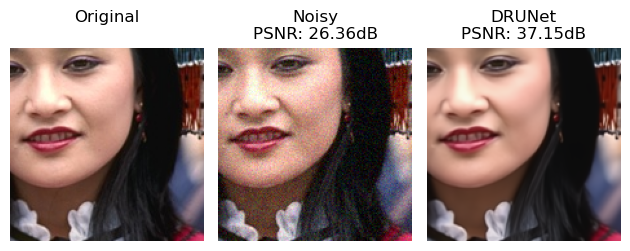

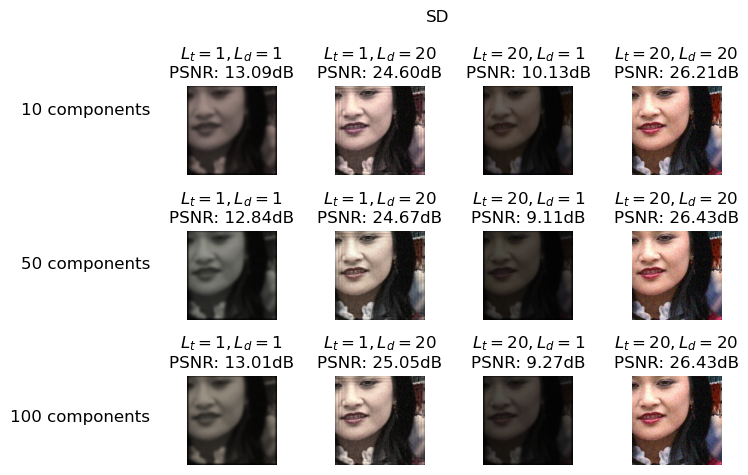

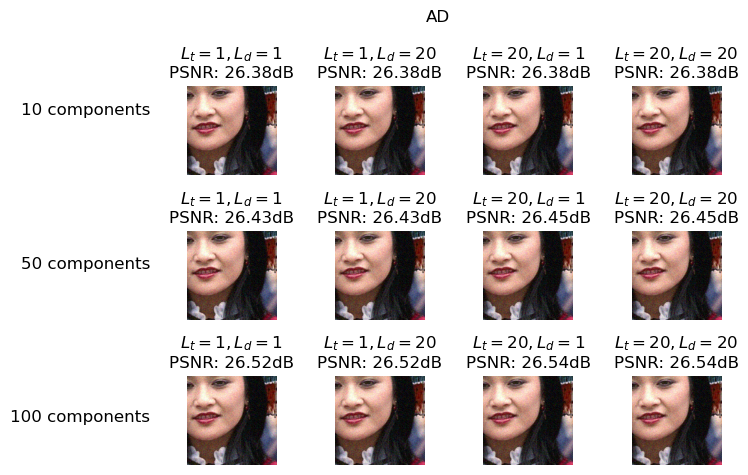

In [144]:
print("Evaluating all denoisers...")
dataloader = create_dataloader(
    DATA_PATH, STD_NOISE, STD_NOISE, device=DEVICE, dtype=torch.float,
    mini_batch_size=1, train=True, random_state=42, color=COLOR,
    download=True, fixed_noise=True
)
img_noise, img = next(iter(dataloader))

n_d = len(DENOISERS)
fig, axes = plt.subplots(1, 3)
axes = axes.flatten()

plot_img(img[0], axes[0], title="Original\n")
psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), img_noise[0].detach().cpu().numpy())
plot_img(img_noise[0], axes[1], title=f"Noisy\nPSNR: {psnr:.2f}dB")
denoise_img = DENOISERS["DRUNet"]["net"](img_noise, STD_NOISE)[0]
psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), denoise_img.detach().cpu().numpy())
plot_img(denoise_img, axes[2], title=f"DRUNet\nPSNR: {psnr:.2f}dB")
plt.tight_layout()
plt.show()

for denoiser_type in ["SD", "AD"]:
    fig, axes = plt.subplots(3, 4)
    axes = axes.flatten()
    i = 0
    for components in [10, 50, 100]:
        name = f"{denoiser_type}_1L_{components}C"
        denoise_img = DENOISERS[name]["net"](img_noise)[0][0]
        psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), denoise_img.detach().cpu().numpy())
        plot_img(denoise_img, axes[i], title=rf"$L_t=1, L_d=1$"+f"\nPSNR: {psnr:.2f}dB")
        i += 1
        
        name = f"{denoiser_type}_1L_{components}C_repeat_20"
        denoise_img = DENOISERS[name]["net"](img_noise)[0][0]
        psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), denoise_img.detach().cpu().numpy())
        plot_img(denoise_img, axes[i], title=rf"$L_t=1, L_d=20$"+f"\nPSNR: {psnr:.2f}dB")
        i += 1
        
        name = f"{denoiser_type}_20L_{components}C_only1"
        denoise_img = DENOISERS[name]["net"](img_noise)[0][0]
        psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), denoise_img.detach().cpu().numpy())
        plot_img(denoise_img, axes[i], title=rf"$L_t=20, L_d=1$"+f"\nPSNR: {psnr:.2f}dB")
        i += 1
        
        name = f"{denoiser_type}_20L_{components}C"
        denoise_img = DENOISERS[name]["net"](img_noise)[0][0]
        psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), denoise_img.detach().cpu().numpy())
        plot_img(denoise_img, axes[i], title=rf"$L_t=20, L_d=20$"+f"\nPSNR: {psnr:.2f}dB")
        i += 1
    
    row_labels = [f"{components} components" for components in [10, 50, 100]]
    for i, label in enumerate(row_labels):
        fig.text(0.05, 0.77 - i * 0.32, label, va='center', ha='right', fontsize=12)
    fig.suptitle(denoiser_type)
    plt.tight_layout(rect=[0.05, 0, 1, 1])
    plt.show()

In [129]:
n_imgs = 100
denoising_results = []
for k, (img_noise, img) in enumerate(dataloader):
    if k == n_imgs:
        print("\rDone computing runtime")
        break
    print(f"\rImage {k}/{n_imgs}", end="")
       
    for denoiser_type in ["SD", "AD"]:
        for components in [10, 50, 100]:
            for name in [f"{denoiser_type}_1L_{components}C", f"{denoiser_type}_1L_{components}C_repeat_20", f"{denoiser_type}_20L_{components}C_only1", f"{denoiser_type}_20L_{components}C", "DRUNet"]:
                with torch.no_grad():
                    t_start = time.perf_counter()
                    if name == "DRUNet":
                        denoise_img = DENOISERS[name]["net"](img_noise, STD_NOISE)[0]
                    else:
                        denoise_img = DENOISERS[name]["net"](img_noise)[0][0]
                    t_end = time.perf_counter()
                    psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), denoise_img.detach().cpu().numpy())
                    denoising_results.append({
                        'id_img': k,
                        'denoiser': name,
                        'runtime': t_end - t_start,
                        'psnr': psnr
                    })

results = pd.DataFrame(denoising_results)

Done computing runtime


In [143]:
mean_per_denoiser = results.groupby('denoiser')["psnr"].agg("mean").to_dict()
std_per_denoiser = results.groupby('denoiser')["psnr"].agg("std").to_dict()

latex_table = r"""
\begin{table}[H]
    \centering
    \begin{tabular}{|c|c|}
        \hline"""
name = "DRUNet"
mean = mean_per_denoiser[name]
std = std_per_denoiser[name]
latex_table += f" {name} & {mean:.2f} $\pm$ {std:.2f}"
latex_table += r"""" \\ \hline
    \end{tabular}
    \caption{Denoising performance (PSNR in dB) of DRUNet (on $100$ images of size $150 \times 150$).}
\end{table}
"""
print(latex_table)

for denoiser_type in ["SD", "AD"]:

    latex_table = r"""
\begin{table}[H]
    \renewcommand{\arraystretch}{1.5}
    \centering
    \begin{tabular}{|c|cc|cc|}
        \hline
        \multirow{2}{*}{\centering\# conv atoms} & \multicolumn{2}{c|}{$L_{train}=1$} & \multicolumn{2}{c|}{$L_{train}=20$} \\
        & $L_{den}=1$ & $L_{den}=20$ & $L_{den}=1$ & $L_{den}=20$ \\ \hline
    """

    for components in [10, 50, 100]:
        latex_table += f"{components}"
        for name in [f"{denoiser_type}_1L_{components}C", f"{denoiser_type}_1L_{components}C_repeat_20", f"{denoiser_type}_20L_{components}C_only1", f"{denoiser_type}_20L_{components}C"]:
            mean = mean_per_denoiser[name]
            std = std_per_denoiser[name]
            latex_table += f" & {mean:.2f} $\pm$ {std:.2f}"
        latex_table += r" \\ \hline" + "\n"

    latex_table += r"""
    \end{tabular}
    \caption{Denoising performance (PSNR in dB) of the""" + f" {denoiser_type} " + r"""(on $100$ images of size $150 \times 150$).}
\end{table}
    """
    print(latex_table)



\begin{table}[H]
    \centering
    \begin{tabular}{|c|c|}
        \hline DRUNet & 35.25 $\pm$ 2.47" \\ \hline
    \end{tabular}
    \caption{Denoising performance (PSNR in dB) of DRUNet (on $100$ images of size $150 \times 150$).}
\end{table}


\begin{table}[H]
    \renewcommand{\arraystretch}{1.5}
    \centering
    \begin{tabular}{|c|cc|cc|}
        \hline
        \multirow{2}{*}{\centering\# conv atoms} & \multicolumn{2}{c|}{$L_{train}=1$} & \multicolumn{2}{c|}{$L_{train}=20$} \\
        & $L_{den}=1$ & $L_{den}=20$ & $L_{den}=1$ & $L_{den}=20$ \\ \hline
    10 & 13.28 $\pm$ 2.14 & 22.98 $\pm$ 2.36 & 10.80 $\pm$ 2.35 & 26.08 $\pm$ 0.21 \\ \hline
50 & 13.23 $\pm$ 2.14 & 24.20 $\pm$ 2.19 & 9.85 $\pm$ 2.38 & 26.25 $\pm$ 0.20 \\ \hline
100 & 13.30 $\pm$ 2.14 & 23.92 $\pm$ 2.34 & 9.98 $\pm$ 2.36 & 26.25 $\pm$ 0.20 \\ \hline

    \end{tabular}
    \caption{Denoising performance (PSNR in dB) of the SD (on $100$ images of size $150 \times 150$).}
\end{table}
    

\begin{table}[H]
    \re

In [149]:
mean_per_denoiser = results.groupby('denoiser')["runtime"].agg("mean").to_dict()
std_per_denoiser = results.groupby('denoiser')["runtime"].agg("std").to_dict()

latex_table = r"""
\begin{table}[H]
    \centering
    \begin{tabular}{|c|c|}
        \hline"""
name = "DRUNet"
mean = mean_per_denoiser[name]
std = std_per_denoiser[name]
latex_table += f" {name} & {1000*mean:.2f} $\pm$ {1000*std:.2f}"
latex_table += r"""" \\ \hline
    \end{tabular}
    \caption{Runtime ($\times 10^{-3}$ s) of DRUNet (on $100$ images of size $150 \times 150$).}
\end{table}
"""
print(latex_table)

for denoiser_type in ["SD", "AD"]:

    latex_table = r"""
\begin{table}[H]
    \renewcommand{\arraystretch}{1.5}
    \centering
    \begin{tabular}{|c|cc|cc|}
        \hline
        \multirow{2}{*}{\centering\# conv atoms} & \multicolumn{2}{c|}{$L_{train}=1$} & \multicolumn{2}{c|}{$L_{train}=20$} \\
        & $L_{den}=1$ & $L_{den}=20$ & $L_{den}=1$ & $L_{den}=20$ \\ \hline
    """

    for components in [10, 50, 100]:
        latex_table += f"{components}"
        for name in [f"{denoiser_type}_1L_{components}C", f"{denoiser_type}_1L_{components}C_repeat_20", f"{denoiser_type}_20L_{components}C_only1", f"{denoiser_type}_20L_{components}C"]:
            mean = mean_per_denoiser[name]
            std = std_per_denoiser[name]
            latex_table += f" & {1000*mean:.2f} $\pm$ {1000*std:.2f}"
        latex_table += r" \\ \hline" + "\n"

    latex_table += r"""
    \end{tabular}
    \caption{Runtime ($\times 10^{-3}$ s) of the""" + f" {denoiser_type} " + r"""(on $100$ images of size $150 \times 150$).}
\end{table}
    """
    print(latex_table)



\begin{table}[H]
    \centering
    \begin{tabular}{|c|c|}
        \hline DRUNet & 18.97 $\pm$ 0.17" \\ \hline
    \end{tabular}
    \caption{Runtime ($\times 10^{-3}$ s) of DRUNet (on $100$ images of size $150 \times 150$).}
\end{table}


\begin{table}[H]
    \renewcommand{\arraystretch}{1.5}
    \centering
    \begin{tabular}{|c|cc|cc|}
        \hline
        \multirow{2}{*}{\centering\# conv atoms} & \multicolumn{2}{c|}{$L_{train}=1$} & \multicolumn{2}{c|}{$L_{train}=20$} \\
        & $L_{den}=1$ & $L_{den}=20$ & $L_{den}=1$ & $L_{den}=20$ \\ \hline
    10 & 0.27 $\pm$ 0.08 & 2.75 $\pm$ 0.03 & 0.17 $\pm$ 0.02 & 2.70 $\pm$ 0.03 \\ \hline
50 & 0.21 $\pm$ 0.05 & 3.91 $\pm$ 0.13 & 0.20 $\pm$ 0.04 & 3.89 $\pm$ 0.13 \\ \hline
100 & 0.22 $\pm$ 0.06 & 5.64 $\pm$ 0.10 & 0.19 $\pm$ 0.04 & 5.63 $\pm$ 0.05 \\ \hline

    \end{tabular}
    \caption{Runtime ($\times 10^{-3}$ s) of the SD (on $100$ images of size $150 \times 150$).}
\end{table}
    

\begin{table}[H]
    \renewcommand{\arraystret

### Deblurring performance

In [8]:
def apply_model(model, x, dual, reg_par, net=None, update_dual=False):

    if model == "unrolled":
        net.set_lmbd(reg_par)
        x_torch = torch.tensor(x, device=DEVICE, dtype=torch.float)[None, :]
        if dual is not None:
            dual = torch.tensor(dual, device=DEVICE, dtype=torch.float)
        with torch.no_grad():
            xnet, new_dual = net(x_torch, dual)
        if not update_dual:
            return xnet.detach().cpu().numpy()[0], None
        else:
            return (
                xnet.detach().cpu().numpy()[0],
                new_dual.detach().cpu().numpy()
            )
    elif model == "identity":
        return x, None
    elif model == "drunet":
        x_torch = torch.tensor(x, device=DEVICE, dtype=torch.float)[None, :]
        with torch.no_grad():
            xnet = net(x_torch, reg_par)
        return np.clip(xnet.detach().cpu().numpy()[0], 0, 1), None


def Phi_channels(x, Phi):

    new_x = np.concatenate(
        [Phi(x[i])[None, :] for i in range(x.shape[0])],
        axis=0
    )

    return new_x


def pnp_deblurring(
    model,
    pth_kernel,
    x_observed,
    reg_par=0.5 * STD_NOISE,
    n_iter=50,
    net=None,
    update_dual=False,
    x_truth=None,
):

    if model in ["analysis", "synthesis"]:
        model = "unrolled"

    # define operators
    Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)

    normPhi2 = op_norm2(Phi, Phit, x_observed.shape)
    # gamma = 1.99 / normPhi2
    gamma = 1.0 / normPhi2

    x_n = Phi_channels(x_observed, Phit)

    cvg, psnr, runtime = [1e10] * n_iter, [0] * n_iter, [0] * n_iter

    current_dual = None
    t_iter = 0
    for k in tqdm(range(0, n_iter)):
        t_start = time.perf_counter()
        g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
        tmp = x_n - gamma * g_n
        x_old = x_n.copy()
        x_n, current_dual = apply_model(
            model, tmp, current_dual, reg_par, net, update_dual
        )
        t_iter += time.perf_counter() - t_start
        cvg[k] = np.sum((x_n - x_old) ** 2)
        runtime[k] = t_iter
        if x_truth is not None:
            psnr[k] = peak_signal_noise_ratio(x_n, x_truth)

    return dict(img=np.clip(x_n, 0, 1), cvg=cvg, psnr=psnr, time=runtime)

In [9]:
dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

In [399]:
pth_kernel = "blur_models/blur_3.mat"


def generate_results_pnp(pth_kernel, img, n_iter=1000, reg_par=0.1):

    h = scipy.io.loadmat(pth_kernel)
    h = np.array(h["blur"])

    Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)
    x_blurred = Phi_channels(img, Phi)
    nc, nxb, nyb = x_blurred.shape
    x_observed = x_blurred + STD_NOISE * np.random.rand(nc, nxb, nyb)
    
    # plt.imshow(x_observed.transpose(1,2,0))
    # plt.show()

    results = {
        "observation": x_observed,
        "truth": img,
        "reg_par": reg_par,
    }
    for name, denoiser in DENOISERS.items():

        if name in sublist_denoisers:
            #print(name)
            results[name] = pnp_deblurring(
                denoiser["model"],
                pth_kernel,
                x_observed,
                n_iter=n_iter,
                reg_par=reg_par,
                update_dual=True,
                net=denoiser["net"],
                x_truth=img,
            )

    return results

In [249]:
sublist_denoisers = ["SD_1L_10C", "SD_1L_50C", "SD_1L_100C"]

In [250]:
print("Running experiments...")
N_EXP = 3
list_results = []
reg_pars = [1e-3, 1e-2]#, 1e-1]
for _ in range(N_EXP):
    print("N_EXP")
    img_noise, img = next(iter(dataloader))
    img_noise, img = img_noise.cpu().numpy()[0], img.cpu().numpy()[0]
    for reg_par in reg_pars:
        print(f"Running reg_par {reg_par}")
        results = generate_results_pnp(pth_kernel, img, reg_par=reg_par, n_iter=1000)
        list_results.append(results)

Running experiments...
N_EXP
Running reg_par 0.001
SD_1L_100C


100%|██████████| 1000/1000 [01:10<00:00, 14.12it/s]


SD_1L_50C


100%|██████████| 1000/1000 [01:06<00:00, 14.98it/s]


SD_1L_10C


100%|██████████| 1000/1000 [00:59<00:00, 16.69it/s]


Running reg_par 0.01
SD_1L_100C


100%|██████████| 1000/1000 [01:11<00:00, 14.07it/s]


SD_1L_50C


100%|██████████| 1000/1000 [01:06<00:00, 15.07it/s]


SD_1L_10C


100%|██████████| 1000/1000 [00:59<00:00, 16.69it/s]


N_EXP
Running reg_par 0.001
SD_1L_100C


100%|██████████| 1000/1000 [01:11<00:00, 14.05it/s]


SD_1L_50C


100%|██████████| 1000/1000 [01:06<00:00, 15.06it/s]


SD_1L_10C


100%|██████████| 1000/1000 [01:00<00:00, 16.61it/s]


Running reg_par 0.01
SD_1L_100C


100%|██████████| 1000/1000 [01:11<00:00, 14.08it/s]


SD_1L_50C


100%|██████████| 1000/1000 [01:06<00:00, 15.03it/s]


SD_1L_10C


100%|██████████| 1000/1000 [01:00<00:00, 16.65it/s]


N_EXP
Running reg_par 0.001
SD_1L_100C


100%|██████████| 1000/1000 [01:11<00:00, 13.99it/s]


SD_1L_50C


100%|██████████| 1000/1000 [01:06<00:00, 15.14it/s]


SD_1L_10C


100%|██████████| 1000/1000 [00:59<00:00, 16.73it/s]


Running reg_par 0.01
SD_1L_100C


100%|██████████| 1000/1000 [01:10<00:00, 14.12it/s]


SD_1L_50C


100%|██████████| 1000/1000 [01:06<00:00, 15.13it/s]


SD_1L_10C


100%|██████████| 1000/1000 [00:59<00:00, 16.74it/s]


In [252]:
len(list_results)

6

In [ ]:
# Save the results early to avoid loosing them.
with open("results.pkl", "wb") as f:
    pickle.dump(list_results, f)

In [ ]:

n_reg = len(reg_pars)
n_denoisers = len(sublist_denoisers)
n_rows = len(list_results)
n_cols = n_denoisers + 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4*n_rows))

for i, results in enumerate(list_results):

    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))

    exponent = int(np.log10(results["reg_par"]))

    cmap = None

    axs[i, 0].set_axis_off()
    axs[i, 0].imshow(x_observed, cmap=cmap)
    axs[i, 0].set_title(r"Observation $y$"+
        f"\nPSNR = {psnr:.2f} dB")
    axs[i, 1].imshow(img, cmap=cmap)
    axs[i, 1].set_title(r"Ground truth $\overline{x}$")
    axs[i, 1].set_axis_off()
    
    j = 0
    for _, name in enumerate(DENOISERS):
        
        if name in sublist_denoisers:
            res = results[name]
            img_result = res['img'].transpose(1, 2, 0).clip(0, 1)
            axs[i, j+2].imshow(img_result, cmap=cmap)
            axs[i, j+2].set_title(
                f"PnP-{name} $\lambda = 10^{{{exponent}}}$\n"
                f"PSNR = {results[name]['psnr'][-1]:0.2f} dB"
            )
            axs[i, j+2].set_axis_off()
            j += 1
    
plt.tight_layout()
plt.savefig("example_images.pdf", dpi=150)
plt.show()
plt.clf()

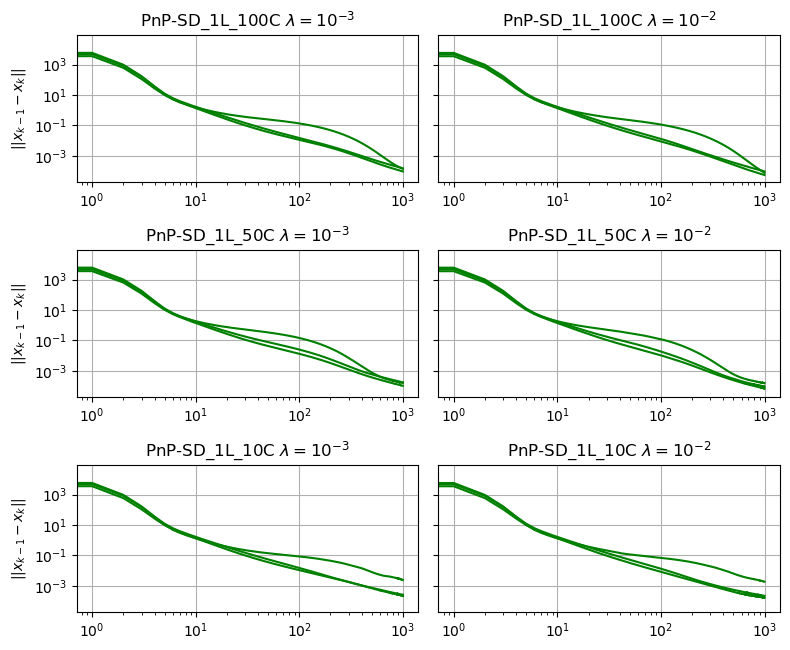

In [284]:
fig, axs = plt.subplots(n_denoisers, n_reg, sharey=True, figsize=(4*n_reg, 2.2*n_denoisers))
for j in range(n_reg):
    # Calculate the exponent for 10^exponent
    exponent = int(np.log10(reg_pars[j]))

    for i, results in enumerate(list_results):
        if results["reg_par"] == reg_pars[j]:
            
            k = 0
            for _, name in enumerate(DENOISERS):
                
                if name in sublist_denoisers:
                    axs[k, j].loglog(results[name]['cvg'], c="green")
                    axs[k, j].set_title(
                        rf"PnP-{name} $\lambda = 10^{{{exponent}}}$"
                    )  # Scientific notation for reg_pars[j]
                    axs[k, j].grid(True)
                    k += 1

# Set the ylable on the first column of each row
for axes in axs:
    axes[0].set_ylabel(r"$||x_{k-1} - x_{k}||$")

plt.tight_layout()
plt.savefig("convergence.pdf")
plt.show()

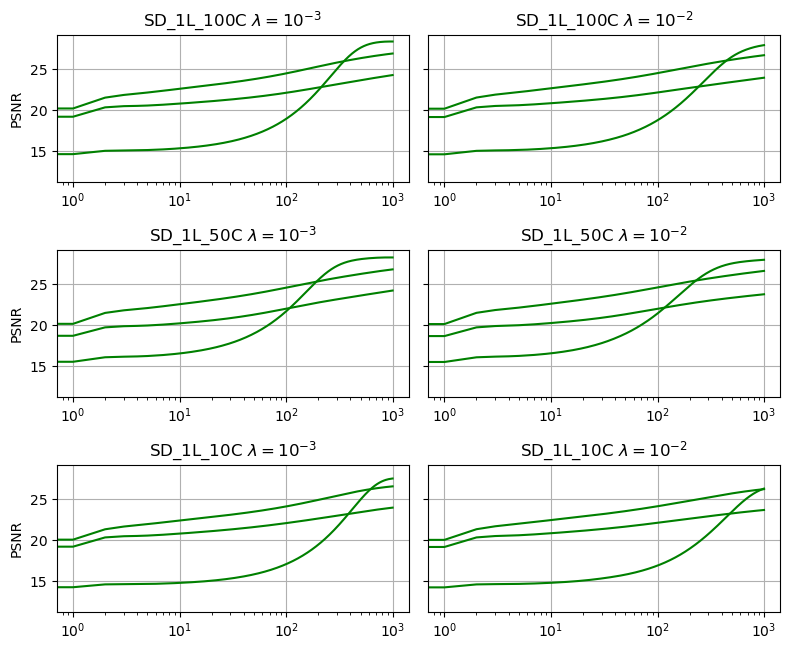

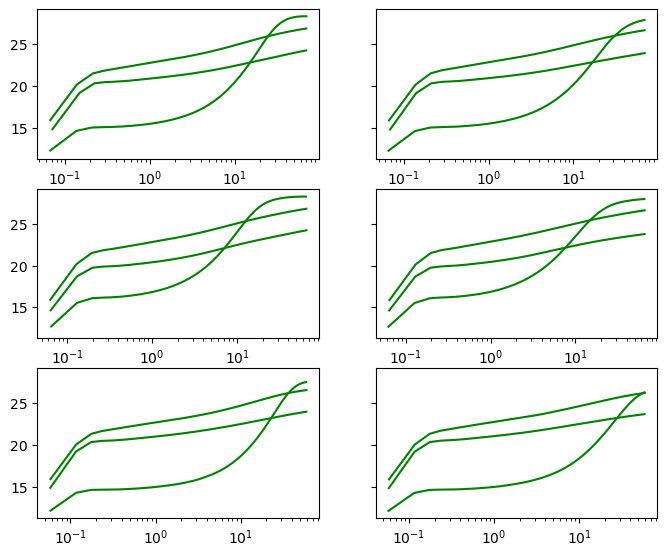

In [285]:
fig, axs = plt.subplots(
    n_denoisers, n_reg, sharey=True, figsize=(4*n_reg, 2.2*n_denoisers)
)
fig_time, axs_time = plt.subplots(
    n_denoisers, n_reg, sharey=True, figsize=(4*n_reg, 2.2*n_denoisers)
)

for j, reg in enumerate(reg_pars):
    exponent = int(np.log10(reg))  # Calculate the exponent for 10^exponent

    for i, results in enumerate(list_results):
        if results["reg_par"] == reg:
            
            k = 0
            for _, name in enumerate(DENOISERS):
                
                if name in sublist_denoisers:
                    res = results[name]
                    axs[k, j].semilogx(res['psnr'], c="green")
                    axs_time[k, j].semilogx(res['time'], res['psnr'], c="green")
                    axs[k, j].set_title(
                        rf"{name} $\lambda = 10^{{{exponent}}}$"
                    )  # Scientific notation for reg
                    axs[k, j].grid(True)
                    k += 1

# Set the ylable on the first column of each row
for axes in axs:
    axes[0].set_ylabel("PSNR")

fig.tight_layout()
fig.savefig("psnr.pdf")
fig_time.savefig("psnr_time.pdf")

### Real denoising task (PnP)

In [348]:
# Create .mat file with a given kernel
def create_blur_kernel(kernel, name):
    kernel = np.array(kernel)
    kernel = kernel / np.sum(kernel)
    scipy.io.savemat(name, {"blur": kernel})
    print(f"Kernel saved in {name}")

kernel = np.zeros((15,15))
kernel[0, 0] = 1
create_blur_kernel(kernel, "blur_models/no_blur.mat")

Kernel saved in blur_models/no_blur.mat


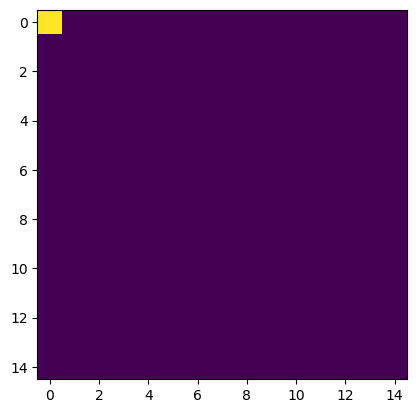

In [365]:
h = scipy.io.loadmat(f"blur_models/no_blur.mat")
h = np.array(h['blur'])
plt.imshow(h)
plt.show()

In [400]:
pth_kernel = "blur_models/no_blur.mat"

In [401]:
Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)
x_blurred = Phi_channels(img, Phi) + STD_NOISE * np.random.rand(*img.shape)

In [402]:
x_blurred.shape

(3, 321, 481)

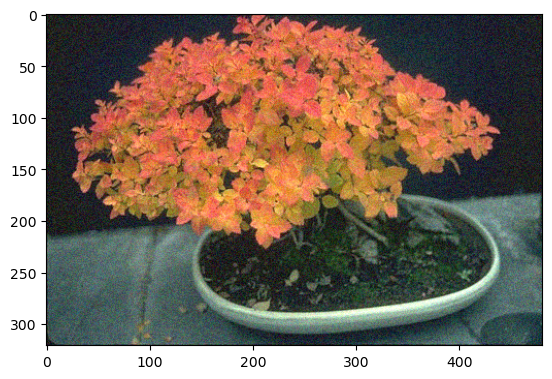

In [403]:
plt.imshow(x_blurred.transpose(1, 2, 0).clip(0, 1))

In [404]:
STD_NOISE = 0.2

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

In [405]:
sublist_denoisers = list(DENOISERS.keys())
sublist_denoisers.remove("SD_20L_10C")
sublist_denoisers.remove("SD_20L_50C")
sublist_denoisers.remove("SD_20L_100C")
sublist_denoisers.remove("AD_20L_10C")
sublist_denoisers.remove("AD_20L_50C")
sublist_denoisers.remove("AD_20L_100C")
sublist_denoisers.remove("SD_20L_10C_only1")
sublist_denoisers.remove("SD_20L_50C_only1")
sublist_denoisers.remove("SD_20L_100C_only1")
sublist_denoisers.remove("AD_20L_10C_only1")
sublist_denoisers.remove("AD_20L_50C_only1")
sublist_denoisers.remove("AD_20L_100C_only1")

In [406]:
print("Running experiments...")
N_EXP = 3
list_results = []
reg_pars = [1e-3, 1e-2]#, 1e-1]
for _ in range(N_EXP):
    print("N_EXP")
    img_noise, img = next(iter(dataloader))
    img_noise, img = img_noise.cpu().numpy()[0], img.cpu().numpy()[0]
    for reg_par in reg_pars:
        #print(f"Running reg_par {reg_par}")
        results = generate_results_pnp(pth_kernel, img, reg_par=reg_par, n_iter=500)
        list_results.append(results)

Running experiments...
N_EXP


100%|██████████| 500/500 [00:35<00:00, 14.23it/s]


N_EXP


100%|██████████| 500/500 [00:34<00:00, 14.33it/s]


N_EXP


100%|██████████| 500/500 [00:34<00:00, 14.30it/s]


In [407]:
len(list_results)

6

In [408]:
# Save the results early to avoid loosing them.
with open("results.pkl", "wb") as f:
    pickle.dump(list_results, f)

In [ ]:
n_reg = len(reg_pars)
n_denoisers = len(sublist_denoisers)
n_rows = len(list_results)
n_cols = n_denoisers + 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4*n_rows))

for i, results in enumerate(list_results):

    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))

    exponent = int(np.log10(results["reg_par"]))

    cmap = None

    axs[i, 0].set_axis_off()
    axs[i, 0].imshow(x_observed, cmap=cmap)
    axs[i, 0].set_title(r"Observation $y$"+
        f"\nPSNR = {psnr:.2f} dB")
    axs[i, 1].imshow(img, cmap=cmap)
    axs[i, 1].set_title(r"Ground truth $\overline{x}$")
    axs[i, 1].set_axis_off()
    
    j = 0
    for _, name in enumerate(DENOISERS):
        
        if name in sublist_denoisers:
            res = results[name]
            img_result = res['img'].transpose(1, 2, 0).clip(0, 1)
            axs[i, j+2].imshow(img_result, cmap=cmap)
            axs[i, j+2].set_title(
                f"PnP-{name} $\lambda = 10^{{{exponent}}}$\n"
                f"PSNR = {results[name]['psnr'][-1]:0.2f} dB"
            )
            axs[i, j+2].set_axis_off()
            j += 1
    
plt.tight_layout()
plt.savefig("example_images.pdf", dpi=150)
plt.show()
plt.clf()

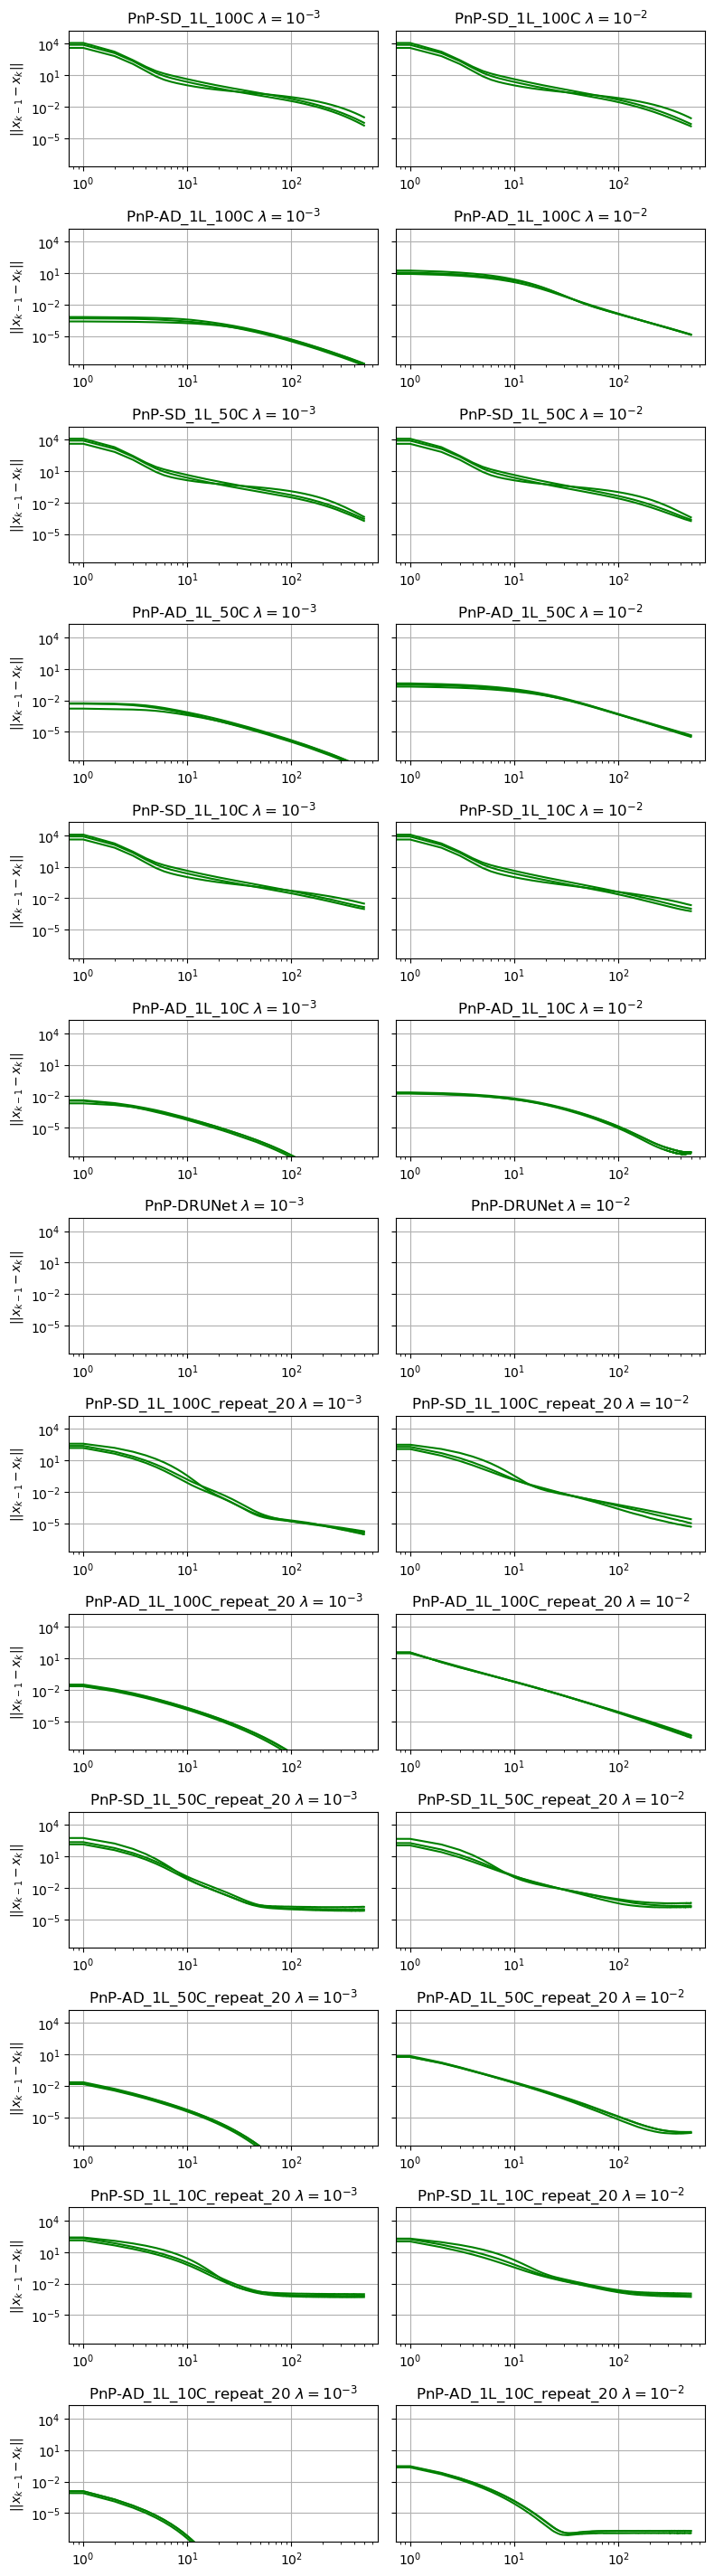

In [410]:
fig, axs = plt.subplots(n_denoisers, n_reg, sharey=True, figsize=(4*n_reg, 2.2*n_denoisers))
for j in range(n_reg):
    # Calculate the exponent for 10^exponent
    exponent = int(np.log10(reg_pars[j]))

    for i, results in enumerate(list_results):
        if results["reg_par"] == reg_pars[j]:
            
            k = 0
            for _, name in enumerate(DENOISERS):
                
                if name in sublist_denoisers:
                    axs[k, j].loglog(results[name]['cvg'], c="green")
                    axs[k, j].set_title(
                        rf"PnP-{name} $\lambda = 10^{{{exponent}}}$"
                    )  # Scientific notation for reg_pars[j]
                    axs[k, j].grid(True)
                    k += 1

# Set the ylable on the first column of each row
for axes in axs:
    axes[0].set_ylabel(r"$||x_{k-1} - x_{k}||$")

plt.tight_layout()
plt.savefig("convergence.pdf")
plt.show()

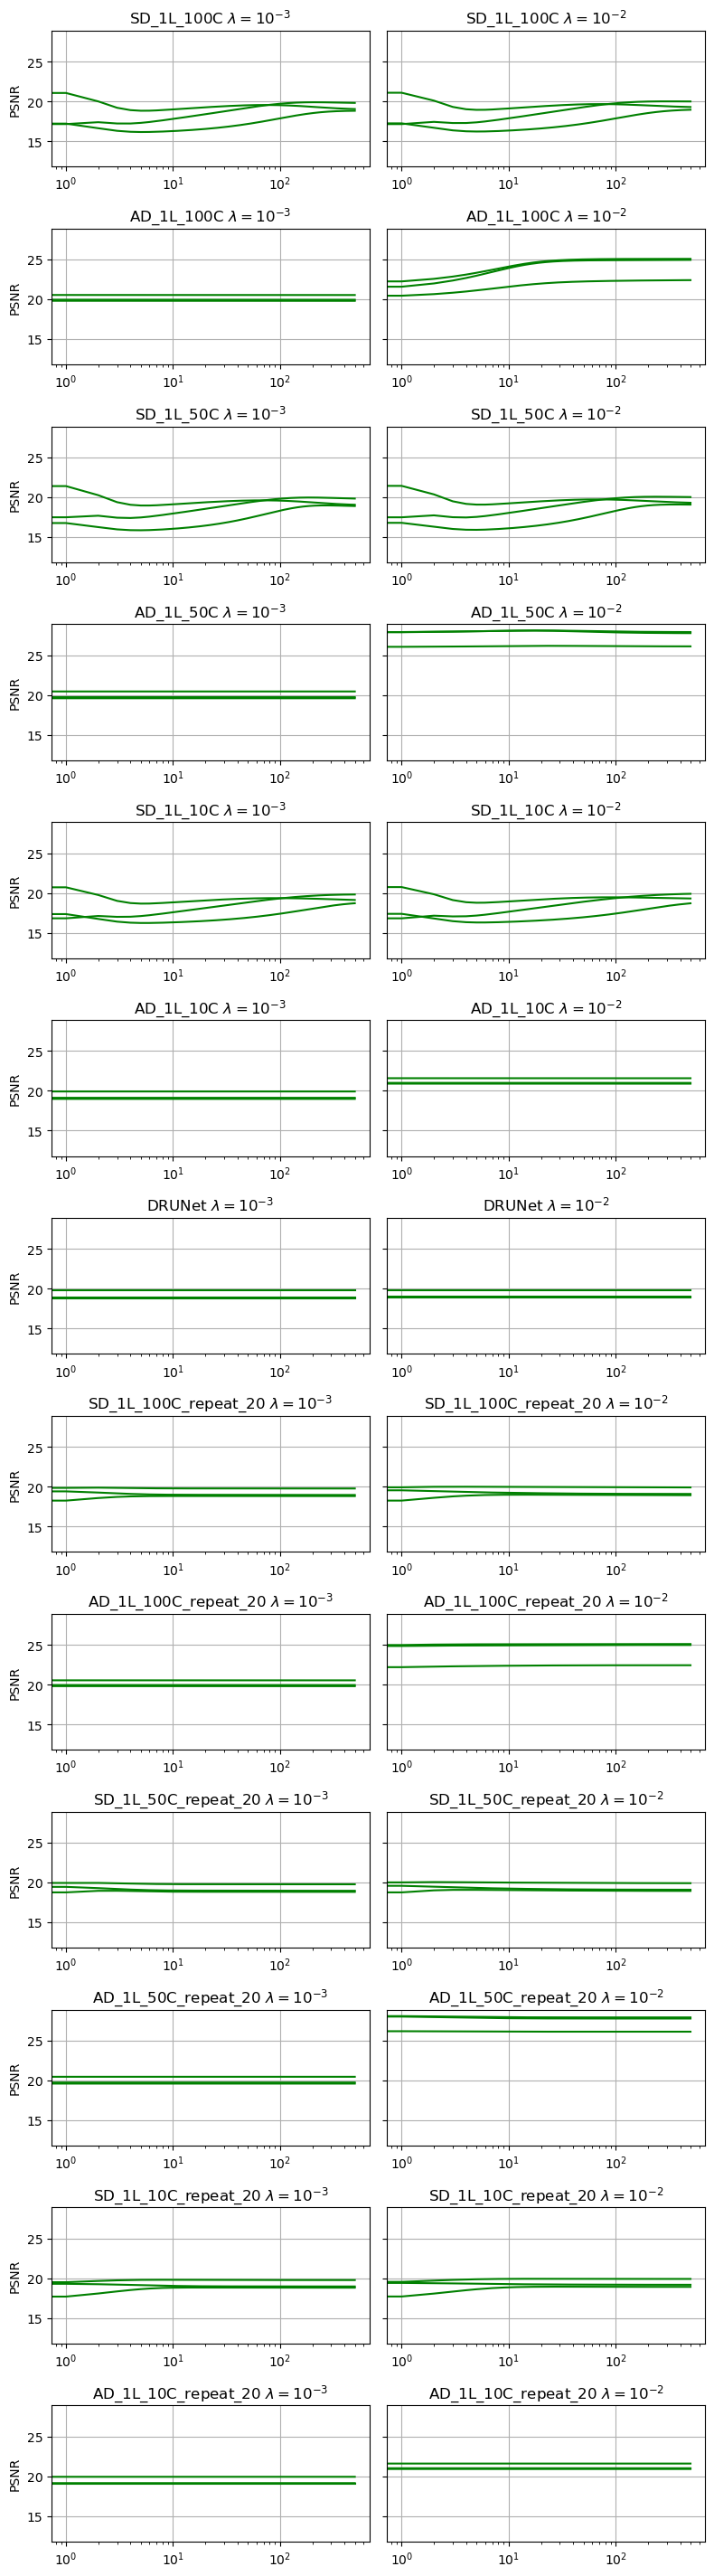

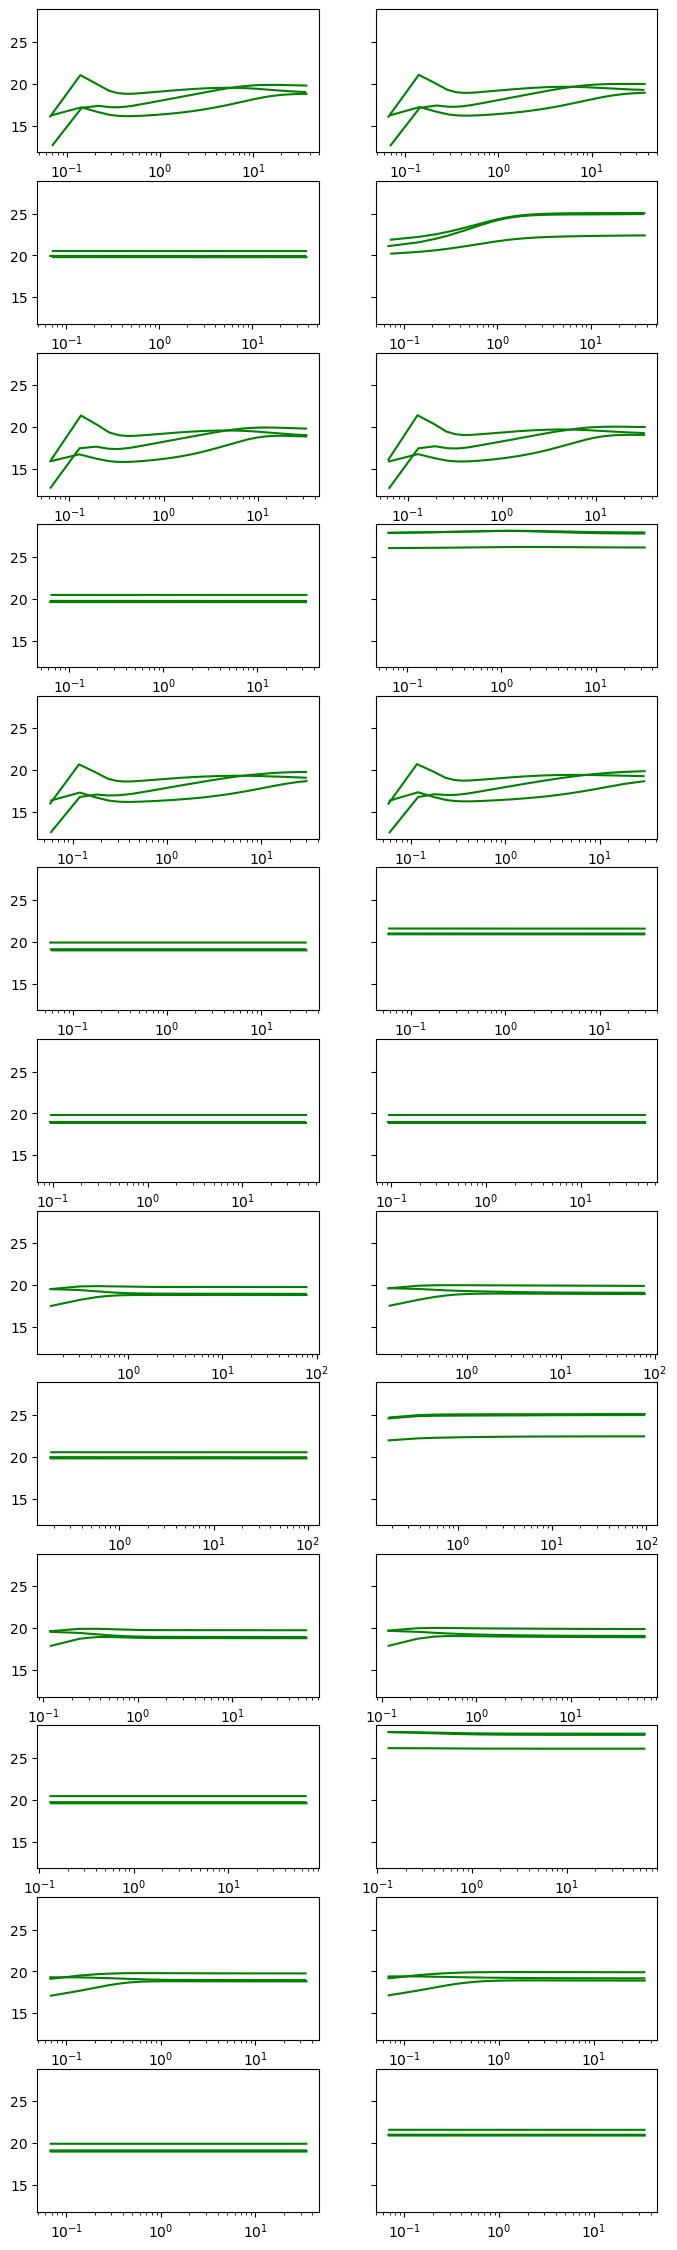

In [411]:
fig, axs = plt.subplots(
    n_denoisers, n_reg, sharey=True, figsize=(4*n_reg, 2.2*n_denoisers)
)
fig_time, axs_time = plt.subplots(
    n_denoisers, n_reg, sharey=True, figsize=(4*n_reg, 2.2*n_denoisers)
)

for j, reg in enumerate(reg_pars):
    exponent = int(np.log10(reg))  # Calculate the exponent for 10^exponent

    for i, results in enumerate(list_results):
        if results["reg_par"] == reg:
            
            k = 0
            for _, name in enumerate(DENOISERS):
                
                if name in sublist_denoisers:
                    res = results[name]
                    axs[k, j].semilogx(res['psnr'], c="green")
                    axs_time[k, j].semilogx(res['time'], res['psnr'], c="green")
                    axs[k, j].set_title(
                        rf"{name} $\lambda = 10^{{{exponent}}}$"
                    )  # Scientific notation for reg
                    axs[k, j].grid(True)
                    k += 1

# Set the ylable on the first column of each row
for axes in axs:
    axes[0].set_ylabel("PSNR")

fig.tight_layout()
fig.savefig("psnr.pdf")
fig_time.savefig("psnr_time.pdf")

### Warm-restart denoising

In [10]:
def pnp_deblurring_warm_restart(
    model,
    pth_kernel,
    x_observed,
    reg_par=None,
    n_iter=50,
    net=None,
    update_dual=False,
    x_truth=None,
):

    if reg_par is None:
        reg_par = [0.5 * STD_NOISE] * n_iter

    if model in ["analysis", "synthesis"]:
        model = "unrolled"

    # define operators
    Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)

    normPhi2 = op_norm2(Phi, Phit, x_observed.shape)
    # gamma = 1.99 / normPhi2
    gamma = 1.0 / normPhi2
    gamma = 2

    x_n = Phi_channels(x_observed, Phit)

    cvg, psnr, runtime = [1e10] * n_iter, [0] * n_iter, [0] * n_iter

    current_dual = None
    t_iter = 0
    for k in tqdm(range(0, n_iter)):
        t_start = time.perf_counter()
        g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
        tmp = x_n - gamma * g_n
        x_old = x_n.copy()
        x_n, current_dual = apply_model(
            model, tmp, current_dual, reg_par[k], net, update_dual
        )
        t_iter += time.perf_counter() - t_start
        cvg[k] = np.sum((x_n - x_old) ** 2)
        runtime[k] = t_iter
        if x_truth is not None:
            psnr[k] = peak_signal_noise_ratio(x_n, x_truth)

    return dict(img=np.clip(x_n, 0, 1), cvg=cvg, psnr=psnr, time=runtime, reg_par=reg_par)

In [11]:
def generate_results_pnp_warm_restart(pth_kernel, img, n_iter=1000, start_reg=1, end_reg=1e-5):

    h = scipy.io.loadmat(pth_kernel)
    h = np.array(h["blur"])

    Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)
    x_blurred = Phi_channels(img, Phi)
    nc, nxb, nyb = x_blurred.shape
    x_observed = x_blurred + STD_NOISE * np.random.rand(nc, nxb, nyb)
    
    # plt.imshow(x_observed.transpose(1,2,0))
    # plt.show()
    reg_par = np.logspace(np.log10(start_reg), np.log10(end_reg), n_iter)
    plt.plot(reg_par)
    plt.show()

    results = {
        "observation": x_observed,
        "truth": img,
        "reg_par": reg_par,
    }
    for name, denoiser in DENOISERS.items():

        if name in sublist_denoisers:
            #print(name)
            results[name] = pnp_deblurring_warm_restart(
                denoiser["model"],
                pth_kernel,
                x_observed,
                n_iter=n_iter,
                reg_par=reg_par,
                update_dual=True,
                net=denoiser["net"],
                x_truth=img,
            )

    return results

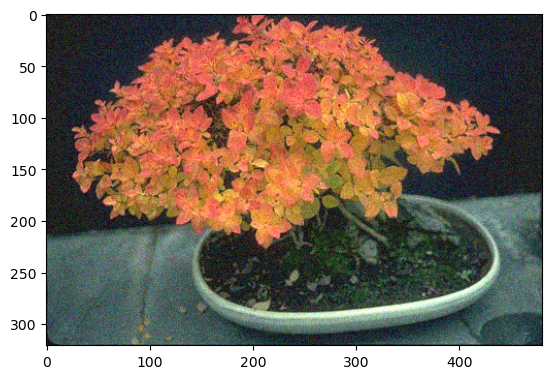

In [12]:
STD_NOISE = 0.2

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

img = next(iter(dataloader))[1].cpu().numpy()[0]

pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"
Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)
x_blurred = Phi_channels(img, Phi) + STD_NOISE * np.random.rand(*img.shape)
x_blurred.shape
plt.imshow(x_blurred.transpose(1, 2, 0).clip(0, 1))

In [30]:
sublist_denoisers = list(DENOISERS.keys())
sublist_denoisers.remove("SD_20L_10C")
sublist_denoisers.remove("SD_20L_50C")
sublist_denoisers.remove("SD_20L_100C")
sublist_denoisers.remove("AD_20L_10C")
sublist_denoisers.remove("AD_20L_50C")
sublist_denoisers.remove("AD_20L_100C")
sublist_denoisers.remove("SD_20L_10C_only1")
sublist_denoisers.remove("SD_20L_50C_only1")
sublist_denoisers.remove("SD_20L_100C_only1")
sublist_denoisers.remove("AD_20L_10C_only1")
sublist_denoisers.remove("AD_20L_50C_only1")
sublist_denoisers.remove("AD_20L_100C_only1")

sublist_denoisers = ["SD_1L_50C", "AD_1L_50C"]#, "SD_1L_100C"]

sublist_denoisers = list(DENOISERS.keys())
for name in list(DENOISERS.keys()):
    if "10C" in name or "100C" in name:
        sublist_denoisers.remove(name)

In [31]:
sublist_denoisers

['SD_20L_50C',
 'AD_20L_50C',
 'SD_1L_50C',
 'AD_1L_50C',
 'DRUNet',
 'SD_1L_50C_repeat_20',
 'AD_1L_50C_repeat_20',
 'SD_20L_50C_only1',
 'AD_20L_50C_only1']

Running experiments...
N_EXP


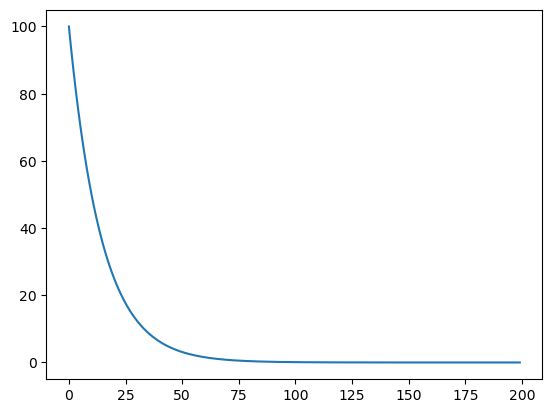

100%|██████████| 200/200 [00:21<00:00,  9.49it/s]


N_EXP


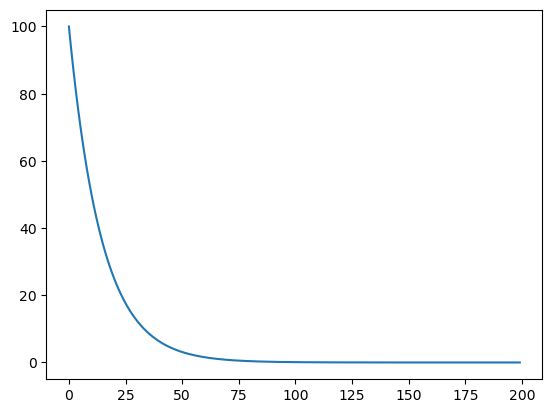

100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


N_EXP


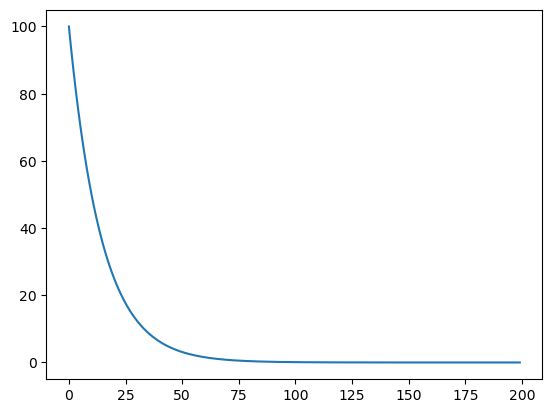

100%|██████████| 200/200 [00:21<00:00,  9.43it/s]


In [33]:
print("Running experiments...")
N_EXP = 3
list_results = []
for _ in range(N_EXP):
    print("N_EXP")
    img_noise, img = next(iter(dataloader))
    img_noise, img = img_noise.cpu().numpy()[0], img.cpu().numpy()[0]
    #print(f"Running reg_par {reg_par}")
    results = generate_results_pnp_warm_restart(pth_kernel, img, n_iter=200, start_reg=100, end_reg=1e-4)
    list_results.append(results)

In [34]:
# Save the results early to avoid loosing them.
with open("results.pkl", "wb") as f:
    pickle.dump(list_results, f)

In [ ]:
n_reg = 1
n_denoisers = len(sublist_denoisers)
n_rows = len(list_results)
n_cols = n_denoisers + 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4*n_rows))

for i, results in enumerate(list_results):

    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))

    exponent_start = int(np.log10(results["reg_par"][0]))
    exponent_end = int(np.log10(results["reg_par"][-1]))

    cmap = None

    axs[i, 0].set_axis_off()
    axs[i, 0].imshow(x_observed, cmap=cmap)
    axs[i, 0].set_title(r"Observation $y$"+
        f"\nPSNR = {psnr:.2f} dB")
    axs[i, 1].imshow(img, cmap=cmap)
    axs[i, 1].set_title(r"Ground truth $\overline{x}$")
    axs[i, 1].set_axis_off()
    
    j = 0
    for _, name in enumerate(DENOISERS):
        
        if name in sublist_denoisers:
            res = results[name]
            img_result = res['img'].transpose(1, 2, 0).clip(0, 1)
            axs[i, j+2].imshow(img_result, cmap=cmap)
            axs[i, j+2].set_title(
                f"PnP-{name} $\lambda: 10^{{{exponent_start}}} -> 10^{{{exponent_end}}}$\n"
                f"PSNR = {results[name]['psnr'][-1]:0.2f} dB"
            )
            axs[i, j+2].set_axis_off()
            j += 1
    
plt.tight_layout()
plt.savefig("example_images.pdf", dpi=150)
plt.show()
plt.clf()

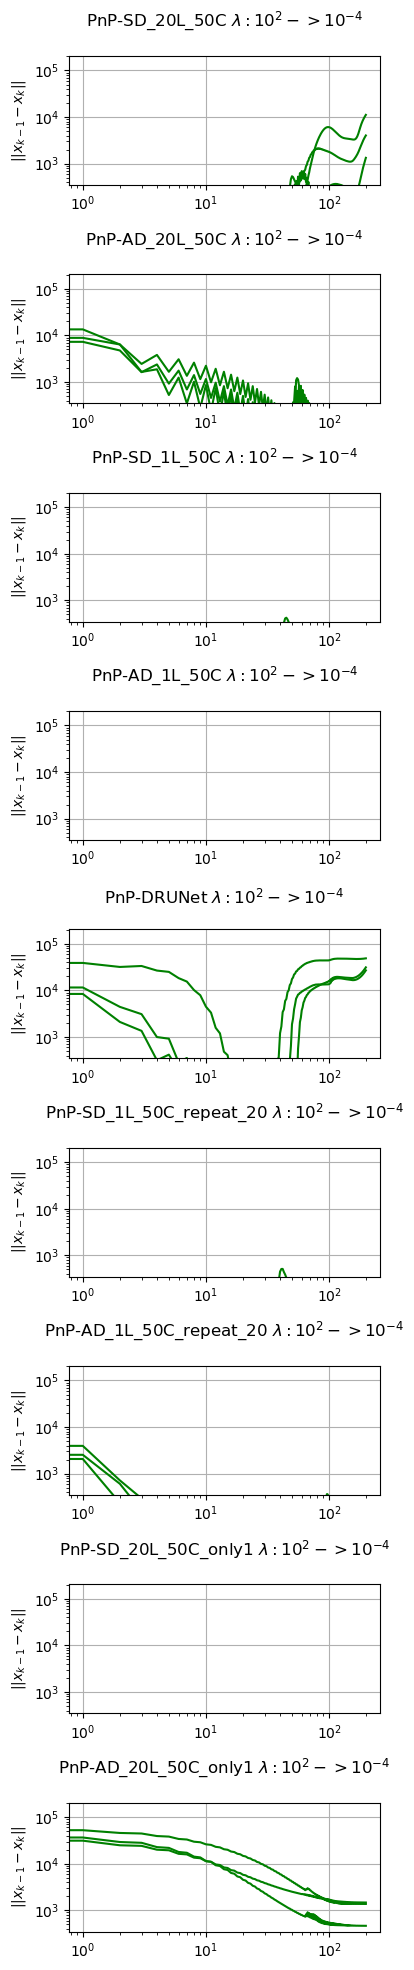

In [36]:
fig, axs = plt.subplots(n_denoisers, n_reg, sharey=True, figsize=(4*n_reg, 2.2*n_denoisers))

# Calculate the exponent for 10^exponent

for i, results in enumerate(list_results):
    k = 0
    
    for _, name in enumerate(DENOISERS):
        
        if name in sublist_denoisers:
            axs[k].loglog(results[name]['cvg'], c="green")
            axs[k].set_title(
                f"PnP-{name} $\lambda: 10^{{{exponent_start}}} -> 10^{{{exponent_end}}}$\n"
            )  # Scientific notation for reg_pars[j]
            axs[k].grid(True)
            k += 1

# Set the ylable on the first column of each row
for axes in axs:
    axes.set_ylabel(r"$||x_{k-1} - x_{k}||$")

plt.tight_layout()
plt.savefig("convergence.pdf")
plt.show()

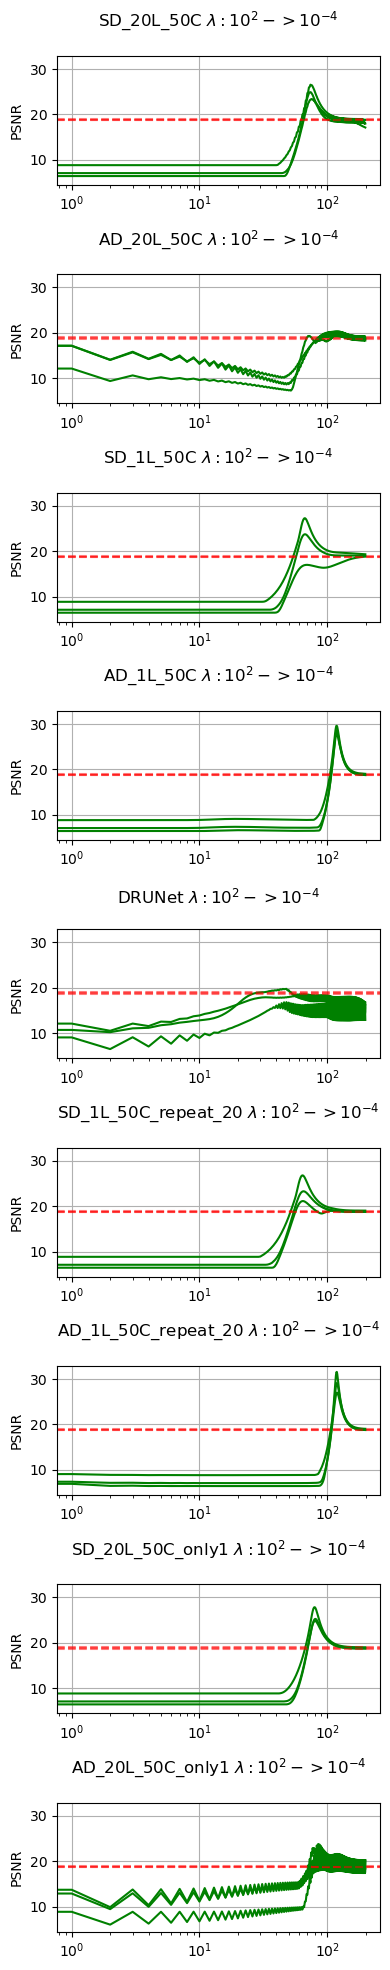

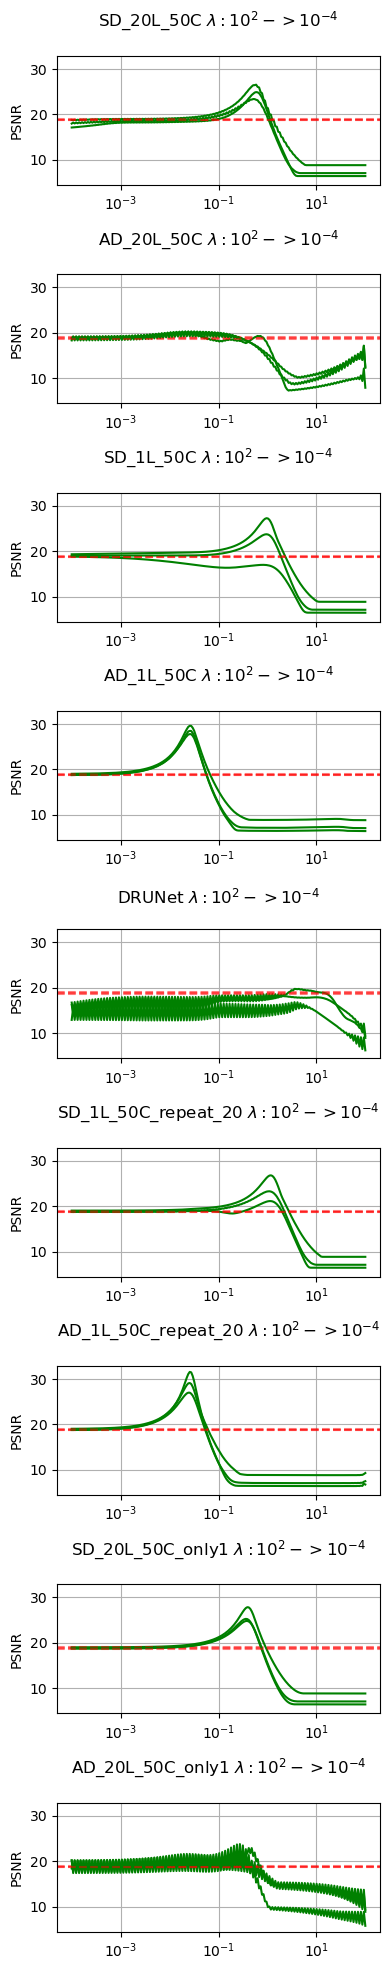

In [37]:
fig, axs = plt.subplots(
    n_denoisers, n_reg, sharey=True, figsize=(4*n_reg, 2.2*n_denoisers)
)
fig_lambda, axs_lambda = plt.subplots(
    n_denoisers, n_reg, sharey=True, figsize=(4*n_reg, 2.2*n_denoisers)
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    k = 0
    for _, name in enumerate(DENOISERS):
        
        if name in sublist_denoisers:
            res = results[name]
            axs[k].semilogx(res['psnr'], c="green")
            axs[k].axhline(y=psnr, color='red', linestyle='--', alpha=0.5)
            axs_lambda[k].semilogx(res['reg_par'], res['psnr'], c="green")
            axs_lambda[k].axhline(y=psnr, color='red', linestyle='--', alpha=0.5)
            axs[k].set_title(
                f"{name} $\lambda: 10^{{{exponent_start}}} -> 10^{{{exponent_end}}}$\n"
            )  # Scientific notation for reg
            axs_lambda[k].set_title(
                f"{name} $\lambda: 10^{{{exponent_start}}} -> 10^{{{exponent_end}}}$\n"
            )  # Scientific notation for reg
            axs[k].grid(True)
            axs_lambda[k].grid(True)
            k += 1

# Set the ylable on the first column of each row
for axes in axs:
    axes.set_ylabel("PSNR")
for axes in axs_lambda:
    axes.set_ylabel("PSNR")

fig.tight_layout()
fig.savefig("psnr.pdf")
fig_lambda.tight_layout()
fig_lambda.savefig("psnr_lambda.pdf")

### Warm-restart deblurring

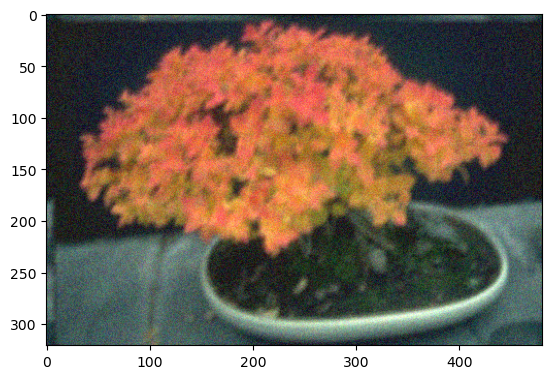

In [46]:
STD_NOISE = 0.2

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

img = next(iter(dataloader))[1].cpu().numpy()[0]

#pth_kernel = "blur_models/no_blur.mat"
pth_kernel = "blur_models/blur_3.mat"
Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)
x_blurred = Phi_channels(img, Phi) + STD_NOISE * np.random.rand(*img.shape)
x_blurred.shape
plt.imshow(x_blurred.transpose(1, 2, 0).clip(0, 1))

In [47]:
sublist_denoisers = list(DENOISERS.keys())
sublist_denoisers.remove("SD_20L_10C")
sublist_denoisers.remove("SD_20L_50C")
sublist_denoisers.remove("SD_20L_100C")
sublist_denoisers.remove("AD_20L_10C")
sublist_denoisers.remove("AD_20L_50C")
sublist_denoisers.remove("AD_20L_100C")
sublist_denoisers.remove("SD_20L_10C_only1")
sublist_denoisers.remove("SD_20L_50C_only1")
sublist_denoisers.remove("SD_20L_100C_only1")
sublist_denoisers.remove("AD_20L_10C_only1")
sublist_denoisers.remove("AD_20L_50C_only1")
sublist_denoisers.remove("AD_20L_100C_only1")

sublist_denoisers = ["SD_1L_50C", "AD_1L_50C"]#, "SD_1L_100C"]

# sublist_denoisers = list(DENOISERS.keys())
# for name in list(DENOISERS.keys()):
#     if "10C" in name or "100C" in name:
#         sublist_denoisers.remove(name)
# sublist_denoisers

Running experiments...
N_EXP


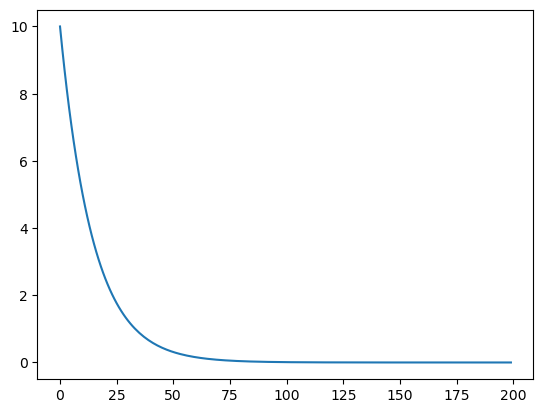

100%|██████████| 200/200 [00:21<00:00,  9.37it/s]


N_EXP


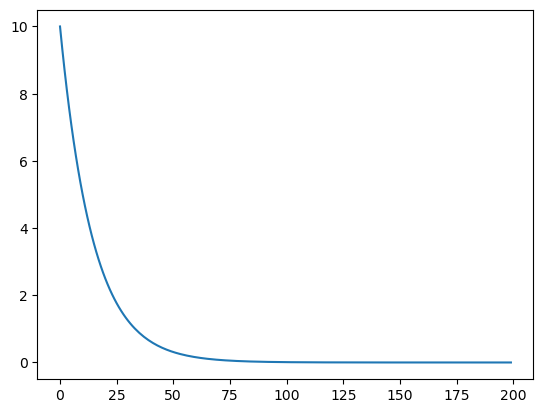

100%|██████████| 200/200 [00:21<00:00,  9.24it/s]


N_EXP


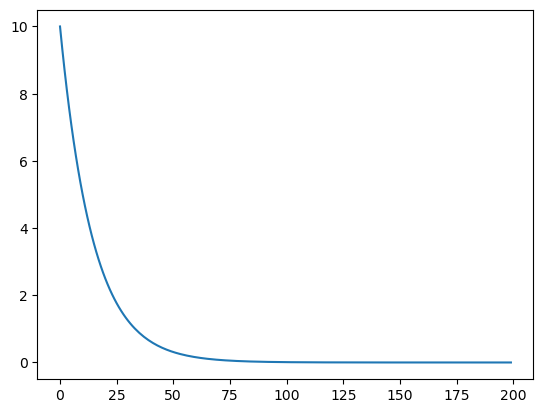

100%|██████████| 200/200 [00:21<00:00,  9.37it/s]


In [48]:
print("Running experiments...")
N_EXP = 3
list_results = []
for _ in range(N_EXP):
    print("N_EXP")
    img_noise, img = next(iter(dataloader))
    img_noise, img = img_noise.cpu().numpy()[0], img.cpu().numpy()[0]
    #print(f"Running reg_par {reg_par}")
    results = generate_results_pnp_warm_restart(pth_kernel, img, n_iter=200, start_reg=10, end_reg=1e-5)
    list_results.append(results)

In [49]:
# Save the results early to avoid loosing them.
with open("results.pkl", "wb") as f:
    pickle.dump(list_results, f)

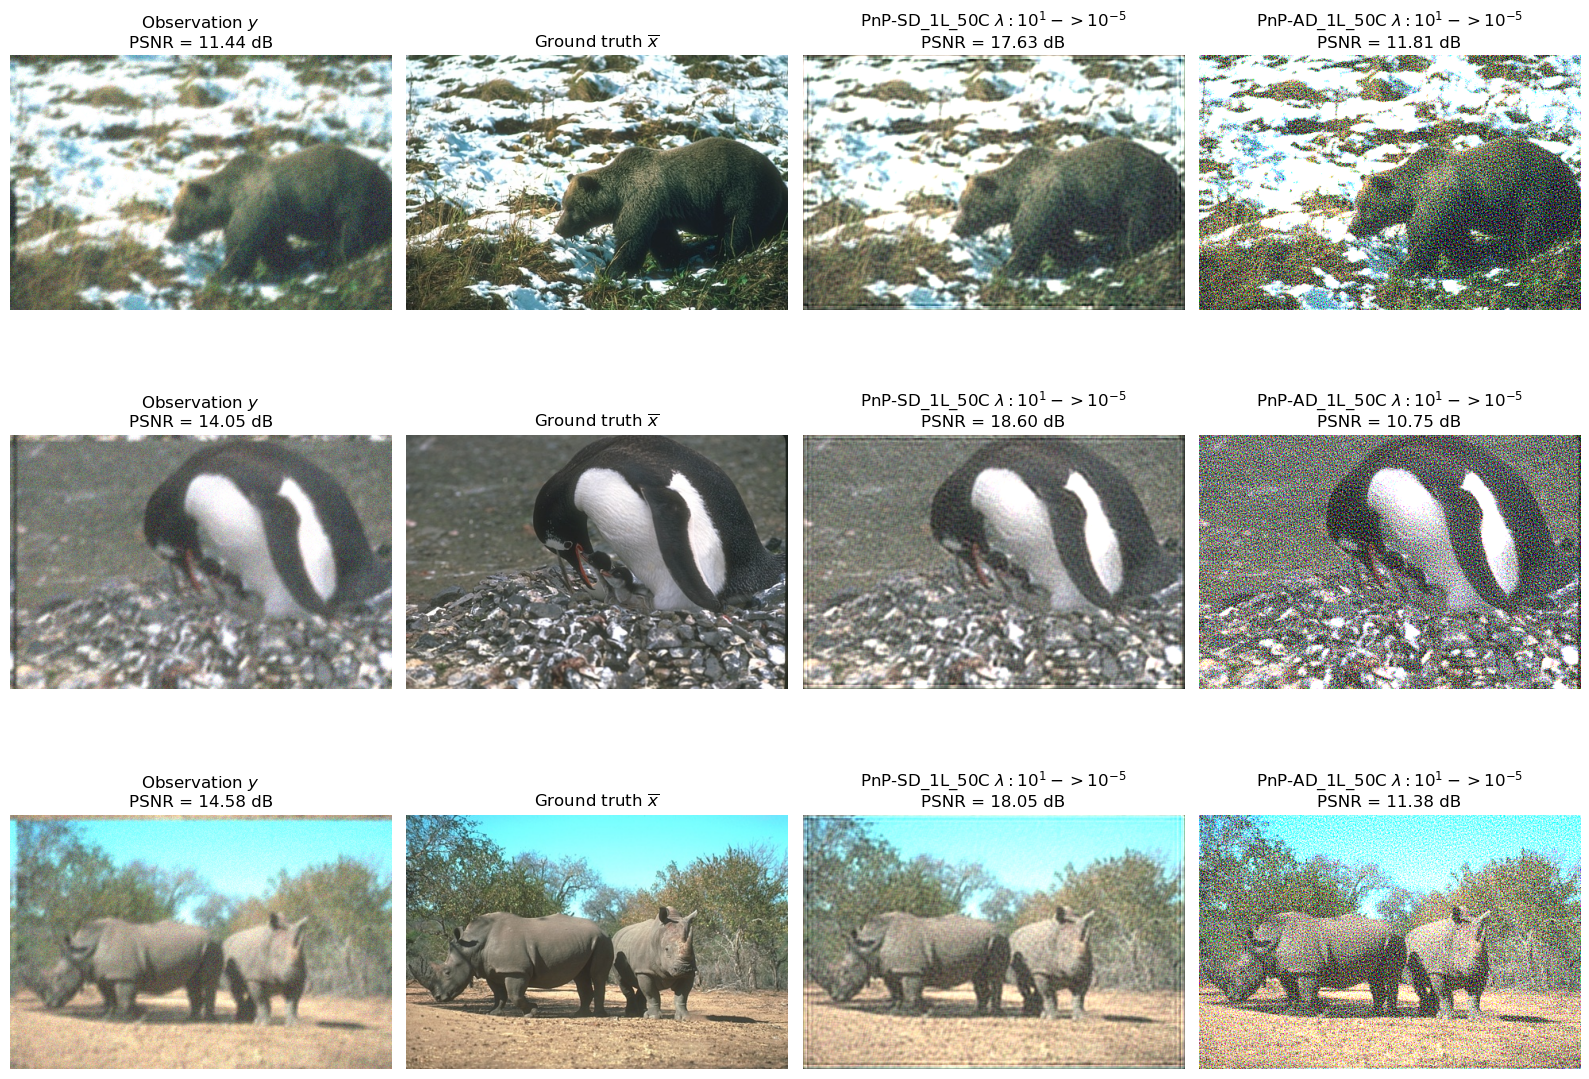

<Figure size 640x480 with 0 Axes>

In [50]:
n_reg = 1
n_denoisers = len(sublist_denoisers)
n_rows = len(list_results)
n_cols = n_denoisers + 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4*n_rows))

for i, results in enumerate(list_results):

    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))

    exponent_start = int(np.log10(results["reg_par"][0]))
    exponent_end = int(np.log10(results["reg_par"][-1]))

    cmap = None

    axs[i, 0].set_axis_off()
    axs[i, 0].imshow(x_observed, cmap=cmap)
    axs[i, 0].set_title(r"Observation $y$"+
        f"\nPSNR = {psnr:.2f} dB")
    axs[i, 1].imshow(img, cmap=cmap)
    axs[i, 1].set_title(r"Ground truth $\overline{x}$")
    axs[i, 1].set_axis_off()
    
    j = 0
    for _, name in enumerate(DENOISERS):
        
        if name in sublist_denoisers:
            res = results[name]
            img_result = res['img'].transpose(1, 2, 0).clip(0, 1)
            axs[i, j+2].imshow(img_result, cmap=cmap)
            axs[i, j+2].set_title(
                f"PnP-{name} $\lambda: 10^{{{exponent_start}}} -> 10^{{{exponent_end}}}$\n"
                f"PSNR = {results[name]['psnr'][-1]:0.2f} dB"
            )
            axs[i, j+2].set_axis_off()
            j += 1
    
plt.tight_layout()
plt.savefig("example_images.pdf", dpi=150)
plt.show()
plt.clf()

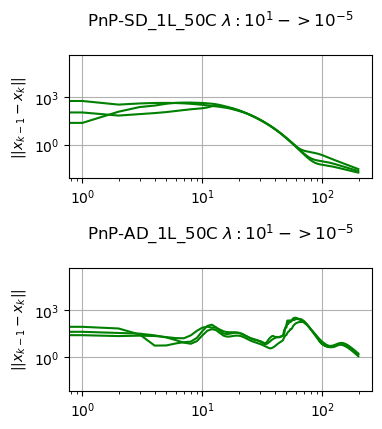

In [51]:
fig, axs = plt.subplots(n_denoisers, n_reg, sharey=True, figsize=(4*n_reg, 2.2*n_denoisers))

# Calculate the exponent for 10^exponent

for i, results in enumerate(list_results):
    k = 0
    
    for _, name in enumerate(DENOISERS):
        
        if name in sublist_denoisers:
            axs[k].loglog(results[name]['cvg'], c="green")
            axs[k].set_title(
                f"PnP-{name} $\lambda: 10^{{{exponent_start}}} -> 10^{{{exponent_end}}}$\n"
            )  # Scientific notation for reg_pars[j]
            axs[k].grid(True)
            k += 1

# Set the ylable on the first column of each row
for axes in axs:
    axes.set_ylabel(r"$||x_{k-1} - x_{k}||$")

plt.tight_layout()
plt.savefig("convergence.pdf")
plt.show()

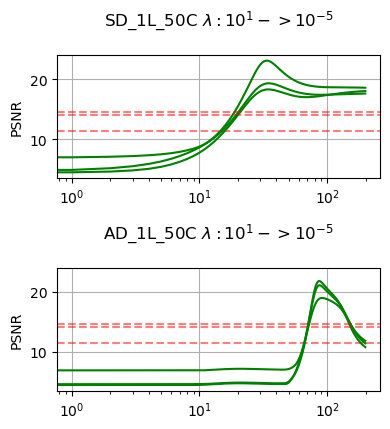

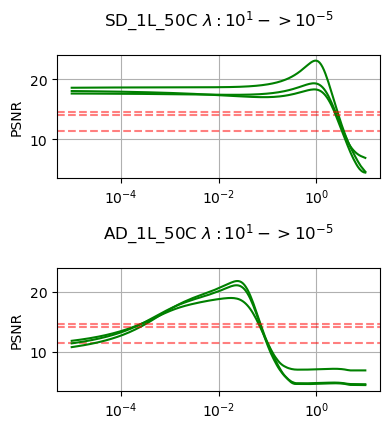

In [52]:
fig, axs = plt.subplots(
    n_denoisers, n_reg, sharey=True, figsize=(4*n_reg, 2.2*n_denoisers)
)
fig_lambda, axs_lambda = plt.subplots(
    n_denoisers, n_reg, sharey=True, figsize=(4*n_reg, 2.2*n_denoisers)
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    k = 0
    for _, name in enumerate(DENOISERS):
        
        if name in sublist_denoisers:
            res = results[name]
            axs[k].semilogx(res['psnr'], c="green")
            axs[k].axhline(y=psnr, color='red', linestyle='--', alpha=0.5)
            axs_lambda[k].semilogx(res['reg_par'], res['psnr'], c="green")
            axs_lambda[k].axhline(y=psnr, color='red', linestyle='--', alpha=0.5)
            axs[k].set_title(
                f"{name} $\lambda: 10^{{{exponent_start}}} -> 10^{{{exponent_end}}}$\n"
            )  # Scientific notation for reg
            axs_lambda[k].set_title(
                f"{name} $\lambda: 10^{{{exponent_start}}} -> 10^{{{exponent_end}}}$\n"
            )  # Scientific notation for reg
            axs[k].grid(True)
            axs_lambda[k].grid(True)
            k += 1

# Set the ylable on the first column of each row
for axes in axs:
    axes.set_ylabel("PSNR")
for axes in axs_lambda:
    axes.set_ylabel("PSNR")

fig.tight_layout()
fig.savefig("psnr.pdf")
fig_lambda.tight_layout()
fig_lambda.savefig("psnr_lambda.pdf")